# Imports

In [996]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.impute import KNNImputer
from sklearn.preprocessing import OneHotEncoder
import ast
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.preprocessing import OrdinalEncoder

In [997]:
# Load the uploaded CSV file
df = pd.read_csv("data/listings.csv")

df.shape

(2772, 79)

Here we can see that there are 79 features and 2772 samples. The next most important thing to check is wether there are any NaN values in our listings dataset

In [998]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2772 entries, 0 to 2771
Data columns (total 79 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   id                                            2772 non-null   int64  
 1   listing_url                                   2772 non-null   object 
 2   scrape_id                                     2772 non-null   int64  
 3   last_scraped                                  2772 non-null   object 
 4   source                                        2772 non-null   object 
 5   name                                          2772 non-null   object 
 6   description                                   2726 non-null   object 
 7   neighborhood_overview                         1437 non-null   object 
 8   picture_url                                   2772 non-null   object 
 9   host_id                                       2772 non-null   i

From the dataset summary compiled above, it is evident that there are some features are indeed missing for some samples, namely neighborhood_overview, host_location, host_above...


In [999]:
# Extract column names and show first few values to infer data types and descriptions
column_info = pd.DataFrame({
    "Feature": df.columns,
    "Example Value": df.iloc[0].values
})

pd.set_option('display.max_rows', None)  # Show all rows
display(column_info)

,Feature,Example Value
0,id,21797474
1,listing_url,https://www.airbnb.com/rooms/21797474
2,scrape_id,20250319035134
3,last_scraped,2025-03-19
4,source,city scrape
5,name,7 Southover Close Westbury On Trym Bristol
6,description,"Beautiful House 4 bedrooms, set in the beautiful area of Westbury on trym Bristol. Garden Back and Front. Local to village and nr by no.1 Bus stop into Centre of Bristol or Near M5 /M4 to London."
7,neighborhood_overview,NaN
8,picture_url,https://a0.muscache.com/pictures/865838a6-ca9a-437e-bdb1-3f3120a5a7b0.jpg
9,host_id,158665944


# Cleaning

Based on all the features of the Bristol AirBnB listings we should begin to drop the uninformative and redundant features.

### Irrelevant Features by Domain Knowledge

These can be primarily `id`s, `url`s, and other irrelevant features that provide no predictive power to the models that will be used later

In [1000]:
irrelevant_features = ["id",
                        "host_id",
                        "host_url", 
                        "listing_url", 
                        "scrape_id", 
                        "last_scraped", 
                        "host_thumbnail_url", 
                        "host_picture_url",
                        "calendar_last_scraped", 
                        "source", 
                        "picture_url", 
                        "host_name", 
                        "host_verifications",
                        "property_type"]

### Minimal Variance Features

In [1001]:
# Features that have the same value across all samples
min_var_feats = df.columns[df.nunique() <= 1].tolist()
min_var_feats

['scrape_id',
 'last_scraped',
 'neighbourhood',
 'neighbourhood_group_cleansed',
 'calendar_updated',
 'has_availability',
 'calendar_last_scraped',
 'license',
 'calculated_host_listings_count_shared_rooms']

### High Missing Values Features

In [1002]:
# Features that have more than 80% of NaN values
missing_feats = df.columns[df.isnull().mean() > 0.8].tolist()
missing_feats


['host_neighbourhood',
 'neighbourhood_group_cleansed',
 'calendar_updated',
 'license']

### Linearly Redundant Features

In [1003]:
# Keep only numeric columns and exclude boolean columns
numeric_df = df.select_dtypes(include='number').drop(columns=df.select_dtypes(include='bool').columns)


# Compute correlation matrix
corr_matrix = numeric_df.corr().abs()

linearly_dependent_feats = []
for i in range(len(corr_matrix.columns)):
    for j in range(i):
        if corr_matrix.iloc[i, j] > 0.9:
            col1 = corr_matrix.columns[i]
            linearly_dependent_feats.append(col1)  # keep the latter

linearly_dependent_feats

['host_total_listings_count',
 'maximum_minimum_nights',
 'maximum_maximum_nights',
 'minimum_nights_avg_ntm',
 'minimum_nights_avg_ntm',
 'maximum_nights_avg_ntm',
 'maximum_nights_avg_ntm',
 'availability_60',
 'availability_90',
 'availability_eoy',
 'number_of_reviews_ly',
 'calculated_host_listings_count_entire_homes']

In [1004]:
target = "price"

### Low Signal and High Cardinality Features

Some features in this dataset have very low signal or extremely high cardinality, like listing names or long descriptions. These columns don’t really help with prediction and can actually make modeling harder or slower, so I’m dropping them from the analysis. This way, I can focus on the features that are more likely to be useful for understanding pricing and guest behavior

In [1005]:
low_signal_high_card_feats = ["name", "description", "neighborhood_overview", "host_about", "amenities"]

### Data Leaking Features

These features are either feedback collected after the price was set, or they're calculated directly from booking data. Including them would leak information into the model that wouldn't be available when setting prices for new listings, so they're not suitable for training a predictive price model.

In [1006]:
data_leak_feats = [
  "estimated_occupancy_l365d", # Depends on price & bookings
  "estimated_revenue_l365d", # Directly derived from price x occupancy
  "review_scores_rating",
  "review_scores_accuracy",
  "review_scores_cleanliness",
  "review_scores_checkin",
  "review_scores_communication",
  "review_scores_location",
  "review_scores_value",
  "reviews_per_month", # Correlated with bookings -> price
  "number_of_reviews_ltm",
  "number_of_reviews_l30d",
  "first_review",
  "last_review"
]

In [1007]:
drop_feats = list(set(
    irrelevant_features +
    min_var_feats +
    missing_feats +
    linearly_dependent_feats +
    [target] +  # Always drop the target variable
    low_signal_high_card_feats +
    data_leak_feats
))

drop_feats

['maximum_nights_avg_ntm',
 'neighborhood_overview',
 'review_scores_cleanliness',
 'last_review',
 'host_name',
 'maximum_maximum_nights',
 'first_review',
 'price',
 'review_scores_rating',
 'calculated_host_listings_count_entire_homes',
 'host_verifications',
 'estimated_occupancy_l365d',
 'id',
 'scrape_id',
 'number_of_reviews_ly',
 'neighbourhood',
 'has_availability',
 'description',
 'host_about',
 'estimated_revenue_l365d',
 'review_scores_location',
 'minimum_nights_avg_ntm',
 'calculated_host_listings_count_shared_rooms',
 'availability_60',
 'host_total_listings_count',
 'review_scores_accuracy',
 'number_of_reviews_ltm',
 'property_type',
 'review_scores_value',
 'last_scraped',
 'calendar_updated',
 'name',
 'picture_url',
 'review_scores_checkin',
 'host_id',
 'neighbourhood_group_cleansed',
 'number_of_reviews_l30d',
 'listing_url',
 'host_neighbourhood',
 'host_thumbnail_url',
 'host_picture_url',
 'availability_eoy',
 'amenities',
 'source',
 'calendar_last_scraped',


In [1008]:
cleaned_feats_df = df.drop(columns=drop_feats)
cleaned_feats_df.shape

(2772, 28)

In [1009]:
cleaned_feats_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2772 entries, 0 to 2771
Data columns (total 28 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   host_since                                    2772 non-null   object 
 1   host_location                                 2230 non-null   object 
 2   host_response_time                            2190 non-null   object 
 3   host_response_rate                            2190 non-null   object 
 4   host_acceptance_rate                          2453 non-null   object 
 5   host_is_superhost                             2732 non-null   object 
 6   host_listings_count                           2772 non-null   int64  
 7   host_has_profile_pic                          2772 non-null   object 
 8   host_identity_verified                        2772 non-null   object 
 9   neighbourhood_cleansed                        2772 non-null   o

# Dropping Samples

Now, we should drop some samples with a high number of missing values, since imputation cannot be done with a high level of reliability, which can introduce bias

In [1010]:
threshold = 0.8
missing_samples = []

# Collect indices of rows with more than 80% missing values
for i in range(len(cleaned_feats_df)):
    if cleaned_feats_df.iloc[i].isnull().sum() / len(cleaned_feats_df.columns) > threshold:
        missing_samples.append(i)

missing_samples


[]

We can also check duplicated samples

In [1011]:
duplicated_samples = cleaned_feats_df.index[cleaned_feats_df.duplicated(keep=False)].tolist()
duplicated_samples

[5, 27, 758, 1196, 1446, 1658, 2268, 2412, 2625]

In [1012]:
cleaned_df = cleaned_feats_df.drop(index=set(duplicated_samples + missing_samples))
cleaned_df.shape

(2763, 28)

### Extreme Outlier detection

At this point, I plan to get rid of samples with extreme outliers. But before doing that, I prefer to visually inspect all the numerical features using histograms. This helps me spot any weird distributions or values that might mess with the analysis later on.

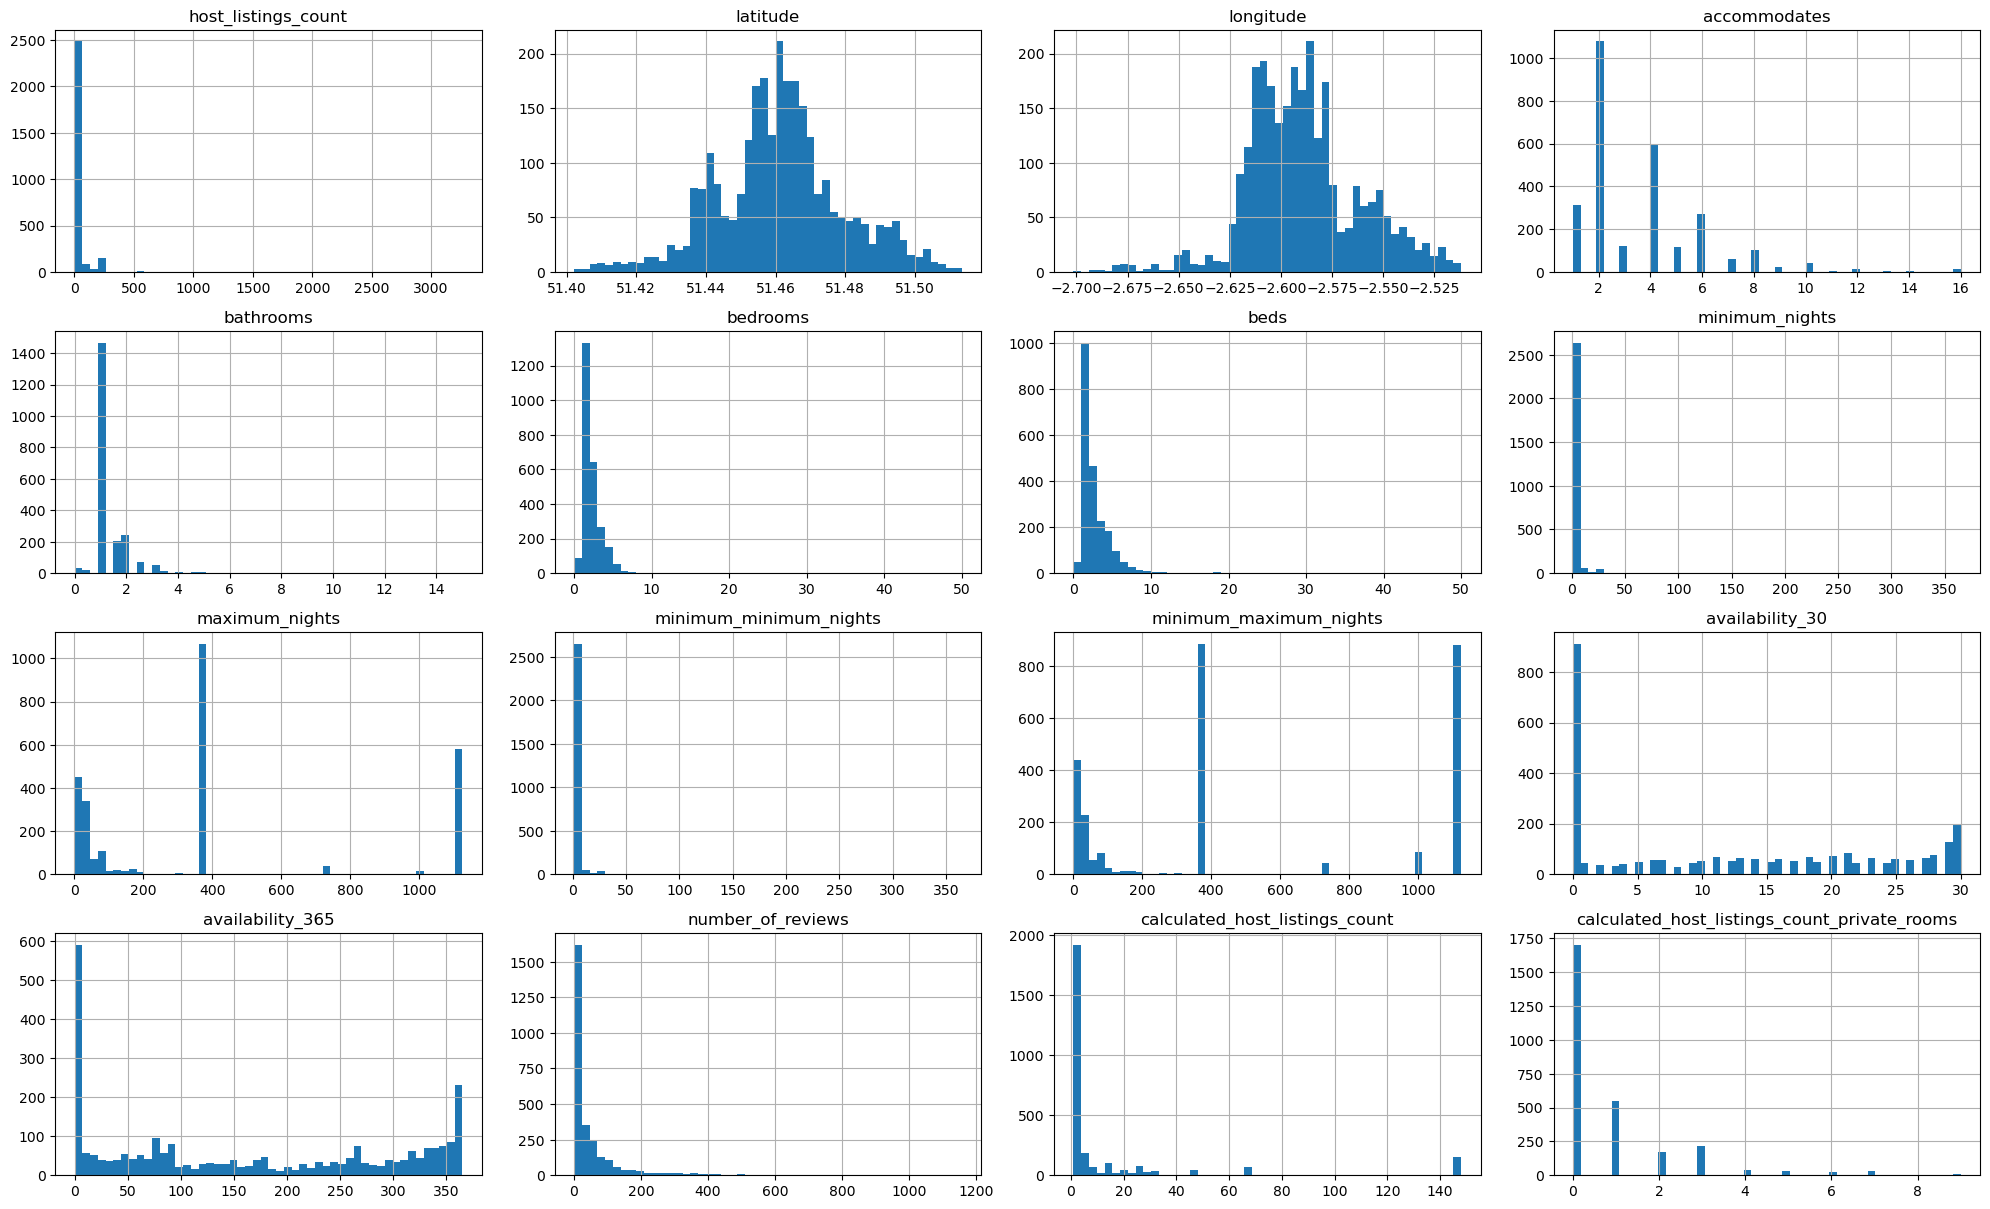

In [1013]:
numeric_cols = cleaned_feats_df.select_dtypes(include=['number']).columns[:32]  # first 32 numeric

# Plot histograms for the selected numeric columns
plt.figure(figsize=(20, 24))  # adjust height as needed
for i, col in enumerate(numeric_cols):
    plt.subplot(8, 4, i+1)  # 8 rows × 4 columns grid
    cleaned_feats_df[col].hist(bins=50)
    plt.title(col)
    plt.tight_layout()

plt.show()

On the histograms above we can visibly see some features have extremely heavy right tails:
- host_listings_count
- calculated_host_listings_count
- calculated_host_listings_count_private_rooms
- maximum_nights
- minimum_nights
- minimum_minimum_nights
- minimum_maximum_nights
- beds
- bedrooms
- bathrooms
- number_of_reviews

But many of these have predictive value, such as:
- `accommodates`, `beds`, `bedrooms`, `bathrooms` affect `price`
- `number_of_reviews`, `availability_365` can be a good proxy for popularity or demand
- `host_listings_count` can reflect host's professionalism

Instead of dropping outliers blindly, we will cap the extreme values, otherwise known as winsorization

In [1014]:
# Compute skewness and 99th percentile caps
skewed_info = []

for col in numeric_cols:
    skew = df[col].skew() 
    p99 = df[col].quantile(0.99)
    skewed_info.append({
        'feature': col,
        'skew': round(skew, 2),
        'p99_cap': round(p99, 2)
    })

# Convert to DataFrame for display
skewed_df = pd.DataFrame(skewed_info).sort_values(by='skew', ascending=False)
skewed_df


,feature,skew,p99_cap
7,minimum_nights,20.26,30.00
9,minimum_minimum_nights,20.24,30.00
0,host_listings_count,18.66,210.00
5,bedrooms,12.95,6.00
6,beds,7.28,9.00
4,bathrooms,6.63,4.00
13,number_of_reviews,4.23,452.87
14,calculated_host_listings_count,3.24,148.00
15,calculated_host_listings_count_private_rooms,2.45,7.00
3,accommodates,1.75,12.00


The table above summarizes the skewness and 99th percentile caps for the main numerical features in the cleaned Airbnb listings dataset. Features like `minimum_nights`, `minimum_minimum_nights`, and `host_listings_count` exhibit extremely high skewness, indicating that most listings have low values but a few have very large values, which can distort analysis and modeling. To address this, we applied winsorization by capping values at their 99th percentile, as shown in the `p99_cap` column. This approach reduces the influence of extreme outliers while preserving the overall distribution of the data, making subsequent analyses and predictive modeling more robust and reliable.

In [1015]:
# Apply 99th percentile cap (winsorization) to each numeric column
for info in skewed_info:
    col = info['feature']
    cap = info['p99_cap']
    cleaned_df[col] = np.where(cleaned_df[col] > cap, cap, cleaned_df[col])

cleaned_df.head()

,host_since,host_location,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_listings_count,host_has_profile_pic,host_identity_verified,neighbourhood_cleansed,latitude,longitude,room_type,accommodates,bathrooms,bathrooms_text,bedrooms,beds,minimum_nights,maximum_nights,minimum_minimum_nights,minimum_maximum_nights,availability_30,availability_365,number_of_reviews,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_private_rooms
0,2017-11-14,"England, United Kingdom",NaN,NaN,NaN,f,1.0,t,t,Westbury-on-Trym & Henleaze,51.49903,-2.61928,Private room,2.0,1.0,1 private bath,1.0,1.0,5.0,14.0,5.0,1125.0,23.0,83.0,0.0,t,1.0,1.0
1,2015-07-23,"Bristol, United Kingdom",a few days or more,0%,NaN,f,1.0,t,f,Brislington West,51.43120,-2.54677,Private room,2.0,1.0,1 shared bath,1.0,1.0,1.0,365.0,1.0,365.0,30.0,365.0,0.0,f,1.0,1.0
2,2015-02-11,"Bristol, United Kingdom",NaN,NaN,0%,f,1.0,t,t,Clifton,51.45346,-2.62255,Entire home/apt,2.0,1.0,1 bath,1.0,1.0,5.0,7.0,5.0,7.0,0.0,291.0,0.0,f,1.0,0.0
3,2014-08-03,"London, United Kingdom",within an hour,100%,73%,f,9.0,t,t,Clifton,51.45442,-2.61984,Entire home/apt,7.0,2.0,2 baths,6.0,7.0,5.0,365.0,5.0,365.0,0.0,259.0,0.0,f,6.0,0.0
4,2015-04-08,"England, United Kingdom",NaN,NaN,NaN,f,3.0,t,t,Easton,51.46935,-2.56476,Private room,4.0,NaN,1 private bath,2.0,NaN,1.0,1125.0,1.0,1125.0,0.0,0.0,11.0,f,3.0,3.0


# Handling NaN values

In [1016]:
cleaned_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2763 entries, 0 to 2771
Data columns (total 28 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   host_since                                    2763 non-null   object 
 1   host_location                                 2221 non-null   object 
 2   host_response_time                            2185 non-null   object 
 3   host_response_rate                            2185 non-null   object 
 4   host_acceptance_rate                          2446 non-null   object 
 5   host_is_superhost                             2723 non-null   object 
 6   host_listings_count                           2763 non-null   float64
 7   host_has_profile_pic                          2763 non-null   object 
 8   host_identity_verified                        2763 non-null   object 
 9   neighbourhood_cleansed                        2763 non-null   object

### Feature Transformations

Before handling missing values, it is important to ensure that all percentage values stored as strings (e.g., "85%") are converted to decimals (e.g., 0.85). This conversion allows imputation methods to treat these columns as numeric rather than object types, preventing errors and ensuring accurate calculations. By standardizing the format of percentage columns early in the preprocessing pipeline, subsequent steps such as filling NaNs with median values or applying advanced imputers like KNNImputer will operate correctly and efficiently on the data. This practice improves data consistency and supports robust feature engineering for downstream modeling.

In [1017]:
# Convert all percentage object values to decimals
for col in cleaned_df.select_dtypes(include='object').columns:
    if cleaned_df[col].str.endswith('%').any():
        cleaned_df[col] = cleaned_df[col].str.rstrip('%').astype(float) / 100

In [1018]:

from sklearn.impute import SimpleImputer, KNNImputer

num_cols = cleaned_df.select_dtypes(include=[np.number]).columns

# <10% missing: fill with median using SimpleImputer
low_missing_cols = [col for col in num_cols if cleaned_df[col].isnull().mean() < 0.1]
if low_missing_cols:
    imputer = SimpleImputer(strategy='median')
    cleaned_df[low_missing_cols] = imputer.fit_transform(cleaned_df[low_missing_cols])

# 10-30% missing: use KNN imputer
mid_missing_cols = [col for col in num_cols if 0.1 <= cleaned_df[col].isnull().mean() < 0.3]
if mid_missing_cols:
    imputer = KNNImputer(n_neighbors=5)
    cleaned_df[mid_missing_cols] = imputer.fit_transform(cleaned_df[mid_missing_cols])

cleaned_df.head()

,host_since,host_location,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_listings_count,host_has_profile_pic,host_identity_verified,neighbourhood_cleansed,latitude,longitude,room_type,accommodates,bathrooms,bathrooms_text,bedrooms,beds,minimum_nights,maximum_nights,minimum_minimum_nights,minimum_maximum_nights,availability_30,availability_365,number_of_reviews,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_private_rooms
0,2017-11-14,"England, United Kingdom",NaN,1.000000,0.966000,f,1.0,t,t,Westbury-on-Trym & Henleaze,51.49903,-2.61928,Private room,2.0,1.000000,1 private bath,1.0,1.000000,5.0,14.0,5.0,1125.0,23.0,83.0,0.0,t,1.0,1.0
1,2015-07-23,"Bristol, United Kingdom",a few days or more,0.000000,0.472000,f,1.0,t,f,Brislington West,51.43120,-2.54677,Private room,2.0,1.000000,1 shared bath,1.0,1.000000,1.0,365.0,1.0,365.0,30.0,365.0,0.0,f,1.0,1.0
2,2015-02-11,"Bristol, United Kingdom",NaN,0.600000,0.000000,f,1.0,t,t,Clifton,51.45346,-2.62255,Entire home/apt,2.0,1.000000,1 bath,1.0,1.000000,5.0,7.0,5.0,7.0,0.0,291.0,0.0,f,1.0,0.0
3,2014-08-03,"London, United Kingdom",within an hour,1.000000,0.730000,f,9.0,t,t,Clifton,51.45442,-2.61984,Entire home/apt,7.0,2.000000,2 baths,6.0,7.000000,5.0,365.0,5.0,365.0,0.0,259.0,0.0,f,6.0,0.0
4,2015-04-08,"England, United Kingdom",NaN,0.964192,0.859166,f,3.0,t,t,Easton,51.46935,-2.56476,Private room,4.0,1.294878,1 private bath,2.0,2.172625,1.0,1125.0,1.0,1125.0,0.0,0.0,11.0,f,3.0,3.0


In [1019]:
cleaned_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2763 entries, 0 to 2771
Data columns (total 28 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   host_since                                    2763 non-null   object 
 1   host_location                                 2221 non-null   object 
 2   host_response_time                            2185 non-null   object 
 3   host_response_rate                            2763 non-null   float64
 4   host_acceptance_rate                          2763 non-null   float64
 5   host_is_superhost                             2723 non-null   object 
 6   host_listings_count                           2763 non-null   float64
 7   host_has_profile_pic                          2763 non-null   object 
 8   host_identity_verified                        2763 non-null   object 
 9   neighbourhood_cleansed                        2763 non-null   object

In [1020]:
# Impute missing values for host_location and host_response_time with 'Unknown'
for col in ["host_location", "host_response_time", "bathrooms_text", "host_is_superhost"]:
    cleaned_df[col] = cleaned_df[col].fillna('Unknown')

In [1021]:
cleaned_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2763 entries, 0 to 2771
Data columns (total 28 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   host_since                                    2763 non-null   object 
 1   host_location                                 2763 non-null   object 
 2   host_response_time                            2763 non-null   object 
 3   host_response_rate                            2763 non-null   float64
 4   host_acceptance_rate                          2763 non-null   float64
 5   host_is_superhost                             2763 non-null   object 
 6   host_listings_count                           2763 non-null   float64
 7   host_has_profile_pic                          2763 non-null   object 
 8   host_identity_verified                        2763 non-null   object 
 9   neighbourhood_cleansed                        2763 non-null   object

# OHE for Categorical Features

Before performing OHE, we need to convert date features to date time and extract useful features. Otherwise, there will be a new feature extracted for each unique date.

In [1022]:
cleaned_df['host_since'] = pd.to_datetime(df['host_since'])

cleaned_df['host_year'] = cleaned_df['host_since'].dt.year
cleaned_df['host_month'] = cleaned_df['host_since'].dt.month
cleaned_df['host_days_active'] = (pd.to_datetime('today') - cleaned_df['host_since']).dt.days

# Drop the original datetime column
cleaned_df = cleaned_df.drop(columns='host_since')

We also have to manipulate host_location

In [1023]:
# Make new binary features based on host_location
cleaned_df['is_uk_host'] = cleaned_df['host_location'].str.contains('United Kingdom', na=False).astype(int)
cleaned_df['outside_uk_host'] = (cleaned_df['is_uk_host'] == 0).astype(int)

cleaned_df.drop("host_location", axis=1, inplace=True)


In [1024]:
cleaned_df['bathrooms_extracted'] = cleaned_df['bathrooms_text'].str.extract(r'(\d+\.?\d*)').astype(float)

cleaned_df.drop("bathrooms_text", axis=1, inplace=True)

In [1025]:
# Define ordered known categories
response_order = [
    'a few days or more',
    'within a day',
    'within a few hours',
    'within an hour'
]

# Replace unknowns (including NaNs) with a placeholder
cleaned_df['host_response_time'] = cleaned_df['host_response_time'].fillna('Unknown')
cleaned_df.loc[~cleaned_df['host_response_time'].isin(response_order), 'host_response_time'] = 'Unknown'

# Add 'Unknown' to the end of your known categories
response_order.append('Unknown')

# Apply encoding
encoder = OrdinalEncoder(categories=[response_order], handle_unknown='use_encoded_value', unknown_value=len(response_order))
cleaned_df['host_response_time_encoded'] = encoder.fit_transform(cleaned_df[['host_response_time']])

cleaned_df.drop("host_response_time", axis=1, inplace=True)


In [1026]:
categorical_cols = cleaned_df.select_dtypes(include=['object', 'category']).columns.tolist()
encoder = OneHotEncoder(drop='first', sparse_output=False)
cleaned_df[categorical_cols] = cleaned_df[categorical_cols].fillna('Missing')

encoded = encoder.fit_transform(cleaned_df[categorical_cols])

# Create a DataFrame for encoded features
encoded_df = pd.DataFrame(encoded, columns=encoder.get_feature_names_out(categorical_cols), index=cleaned_df.index)

# Concatenate with the original dataframe (excluding original categorical columns)
cleaned_df_ohe = pd.concat([cleaned_df.drop(columns=categorical_cols), encoded_df], axis=1)

cleaned_df_ohe.shape

(2763, 65)

In [1027]:
cleaned_df_ohe.head()

,host_response_rate,host_acceptance_rate,host_listings_count,latitude,longitude,accommodates,bathrooms,bedrooms,beds,minimum_nights,maximum_nights,minimum_minimum_nights,minimum_maximum_nights,availability_30,availability_365,number_of_reviews,calculated_host_listings_count,calculated_host_listings_count_private_rooms,host_year,host_month,host_days_active,is_uk_host,outside_uk_host,bathrooms_extracted,host_response_time_encoded,host_is_superhost_f,host_is_superhost_t,host_has_profile_pic_t,host_identity_verified_t,neighbourhood_cleansed_Avonmouth & Lawrence Weston,neighbourhood_cleansed_Bedminster,neighbourhood_cleansed_Bishopston & Ashley Down,neighbourhood_cleansed_Bishopsworth,neighbourhood_cleansed_Brislington East,neighbourhood_cleansed_Brislington West,neighbourhood_cleansed_Central,neighbourhood_cleansed_Clifton,neighbourhood_cleansed_Clifton Down,neighbourhood_cleansed_Cotham,neighbourhood_cleansed_Easton,neighbourhood_cleansed_Eastville,neighbourhood_cleansed_Filwood,neighbourhood_cleansed_Frome Vale,neighbourhood_cleansed_Hartcliffe & Withywood,neighbourhood_cleansed_Henbury & Brentry,neighbourhood_cleansed_Hengrove & Whitchurch Park,neighbourhood_cleansed_Hillfields,neighbourhood_cleansed_Horfield,neighbourhood_cleansed_Hotwells & Harbourside,neighbourhood_cleansed_Knowle,neighbourhood_cleansed_Lawrence Hill,neighbourhood_cleansed_Lockleaze,neighbourhood_cleansed_Redland,neighbourhood_cleansed_Southmead,neighbourhood_cleansed_Southville,neighbourhood_cleansed_St George Central,neighbourhood_cleansed_St George Troopers Hill,neighbourhood_cleansed_St George West,neighbourhood_cleansed_Stockwood,neighbourhood_cleansed_Stoke Bishop,neighbourhood_cleansed_Westbury-on-Trym & Henleaze,neighbourhood_cleansed_Windmill Hill,room_type_Hotel room,room_type_Private room,instant_bookable_t
0,1.000000,0.966000,1.0,51.49903,-2.61928,2.0,1.000000,1.0,1.000000,5.0,14.0,5.0,1125.0,23.0,83.0,0.0,1.0,1.0,2017,11,2816,1,0,1.0,4.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0
1,0.000000,0.472000,1.0,51.43120,-2.54677,2.0,1.000000,1.0,1.000000,1.0,365.0,1.0,365.0,30.0,365.0,0.0,1.0,1.0,2015,7,3661,1,0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,0.600000,0.000000,1.0,51.45346,-2.62255,2.0,1.000000,1.0,1.000000,5.0,7.0,5.0,7.0,0.0,291.0,0.0,1.0,0.0,2015,2,3823,1,0,1.0,4.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1.000000,0.730000,9.0,51.45442,-2.61984,7.0,2.000000,6.0,7.000000,5.0,365.0,5.0,365.0,0.0,259.0,0.0,6.0,0.0,2014,8,4015,1,0,2.0,3.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.964192,0.859166,3.0,51.46935,-2.56476,4.0,1.294878,2.0,2.172625,1.0,1125.0,1.0,1125.0,0.0,0.0,11.0,3.0,3.0,2015,4,3767,1,0,1.0,4.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
